# DASHBOARDS ONS

# CODE

In [1]:
import panel as pn
import pandas as pd
import holoviews as hv
import hvplot.pandas
from bokeh.plotting import figure
from datetime import datetime, date, timedelta
from bokeh.models.formatters import DatetimeTickFormatter

from infra_copel import MongoHistoricoOficial
pn.extension("tabulator", template="material", sizing_mode="stretch_width")
hv.renderer('bokeh').theme = 'light_minimal'

### ESTILO
classes, functions and variables for styles, as HTML, CSS, package python as Panel, Bokeh and Holoviz.


In [2]:
class DashboardStyle:

    def __init__(self):
        """
        Construtor inicializa os estilos e padrão de cores.
            
        Exemplo
        --------
            title_name = "EAR por Reservatório"
            layout = DashboardStyle()
            layout.render_title(title_name="teste", is_title_tab=False)
    
        """
        self.title_name = ""
        self.description_data = ""
        
        # Constantes e cores
        self.copel_orange = "#F57C00"
        self.light_orange = "#FFE0B2"
        self.new_black = "#212121"
        self.light_grey = "#EEEEEE"
        self.background_grey = "#BDBDBD"
        self.description_grey = "#424242"
        
        self.palette_colors = ['#025259', '#007172', '#F29325', '#D94F04', 'black']
        
        self.default_style = {"color": self.copel_orange,
                              "padding": "5px",
                              "margin-left": "70px"}
        
        self.description_style = {"color": self.description_grey,
                                 "background-color": self.background_grey,
                                 "padding": "10px",
                                 "border": "2px solid #ddd",
                                 "border-width": "2px",
                                 "border-radius": "8px",}
        
        self.plot_style = {"background": self.background_grey,
                           "border-color": "darkgrey",
                           "border-width": "2px",
                           "border-radius": "8px",
                           "margin": "13px",
                           "padding": "10px"}
    
        self.tab_style = {"font-size": "18px",
                          "background": self.light_grey,
                          "color": self.copel_orange,
                          "padding": "0.5em 1em",
                          "margin": "0.25em",
                          "margin-right": "10px",
                          "hover-background": self.copel_orange}

        # Renderizar imagem
        IMAGE_PATH = "assets/logo-ons-desktop.png"
        self.png_pane = pn.pane.Image(IMAGE_PATH, width=120)
        
    def render_title(self, title_name: str, is_title_tab=False) -> pn.panel:
        """
        Renderiza um título para o painel.
        
        Parâmetros
        ----------
        title_name : str
            O nome do título.
        is_title_tab : bool, default False
            Indica se o título é para uma guia ou título principal do dashboard.
        
        Retorna
        -------
        panel
            Um objeto Panel contendo o título renderizado.
        """
        title_name = title_name.upper()
        self.title_name = title_name

        # Ternário
        color = self.light_orange if is_title_tab else self.background_grey
        background_color = self.copel_orange if is_title_tab else self.new_black
    
        title_html = f"<h1>{self.title_name}</h1>"
        
        styles_def={"color": color,
                    "background-color": background_color,
                    "font-size": "15px",
                    "text-align": "center",
                    "padding": "10px",
                    "width": "100%",
                    "border-radius": "5px"}
                
        if is_title_tab:
            title_layout = pn.Row(
                self.png_pane,
                title_html,
                styles=styles_def)
        else:
            title_layout = pn.panel(title_html,
                                    styles=styles_def)
        
        return title_layout

    def render_generate_legend(self, colors: list[str], descriptions: list) -> pn.panel:
        """
        Renderiza uma legenda para o painel.
        
        Parâmetros
        ----------
        colors : list[str]
            Lista de cores para os itens da legenda.
        descriptions : list
            Lista de descrições para os itens da legenda.
        
        Retorna
        -------
        panel
            Um objeto Panel contendo a legenda renderizada.

        Example
        --------
            paleta = ['#025259', '#007172', '#F29325', '#D94F04', 'black']
            descriptions = [2020, 2021, 2022, 2023, 2024]
            render_generate_legend(paleta, descriptions)
        """
        subtitle_html = f"""<p> legenda:"""
        
        for color, description in zip(colors, descriptions):
            subtitle_html += f"""<span style="display: inline-block; width: 28px; height: 5px; margin-left: 20px; background-color: {color};"></span> {description}"""
    
        subtitle_html += "</p>"
        return pn.panel(subtitle_html, styles=self.description_style)

    def render_description(self, description_html: str) -> pn.panel:
        return pn.panel(description_html, styles=self.description_style)

    def render_tab(self, *tuples):
        for arg in tuples:
            if not isinstance(arg, tuple):
                raise ValueError("Os argumentos devem ser tuplas")

        tab = pn.Tabs(tuples, styles=self.tab_style)
        return tab

    def render_info(self, html_text: str) -> pn.panel:
        return pn.panel(html_text, styles=self.default_style)
        
    def render_loading(self, icon_size: int=50, name: str="Aguarde . . .") -> pn.panel:
        """
        Renderiza um indicador de spinner de carregamento.
        
        Parâmetros
        ----------
        icon_size : int, padrão 50
            O tamanho do ícone de carregamento.
        name : str, padrão "Aguarde . . ."
            O nome exibido ao lado do spinner de carregamento.
        
        Retorna
        -------
        pn.panel
            Um objeto LoadingSpinner.
        """
        return  pn.indicators.LoadingSpinner(value=True, 
                                             size=icon_size, 
                                             name=name)
              


## FUNÇÕES COMUNS (UTILS)
Funções em comum usados em todos em dashboards, como a requisição ao banco de dados, MongoDB.

In [3]:
def collection_connect(collection_name: str):
    """
    Conecta-se a uma coleção no banco de dados MongoDB.
    """
    return MongoHistoricoOficial()[collection_name]

def query_data(collection, query: dict, projection: dict) -> list:
    """
    Executa uma consulta na collection especificada.

    Parâmetros
    ----------
    collection : pymongo.collection.Collection
        A coleção na qual a consulta será realizada.
    query : dict
        O filtro da consulta.
    projection : dict
        As projeções dos campos retornados.

    Retorna
    -------
    list
        Uma lista contendo os documentos.
    """
    return list(collection.find(query, projection))
        
def create_filter_select(collection, 
                         field_of_mongo: str, 
                         widget_styles: dict=None, 
                         description_name: str="Selecione uma opção: ", 
                         value_name: str="") -> pn.panel:
    """
    Cria um widget de seleção a partir dos valores únicos de um campo de uma collection.

    Parâmetros
    ----------
    collection : pymongo.collection.Collection
        A coleção MongoDB da qual os valores serão extraídos.
    widget_styles : dict
        O estilo a ser aplicado ao widget de seleção.
    field : str
        O nome do campo na coleção MongoDB.
    description_name : str, opcional
        O texto de descrição para o widget de seleção.
    value_name : str, opcional
        O valor inicial selecionado no widget de seleção.

    Retorna
    -------
    pn.panel
        Um painel contendo o widget de seleção.
    """
    if widget_styles == None:
        layout = DashboardStyle()
        default_style = layout.plot_style
    else:
        default_style = widget_styles
        
    elements_list = collection.distinct(field_of_mongo)
    filter_widget = pn.widgets.Select(options=elements_list,
                                      name=description_name,
                                      value=value_name,
                                      styles=default_style)
    return filter_widget

    
def create_line_chart(data: list[dict] | pd.DataFrame, 
                      x: str, 
                      y: str,
                      by: str = None,
                      xlabel: str = None, 
                      ylabel: str = None, 
                      width: int = 1150, 
                      height: int = 800, 
                      legend: bool = True, 
                      title: str = "", 
                      palette_colors: list[str] = None):

    """
    Cria um gráfico de linha.

    Parâmetros
    ----------
    data : list[dict] | pd.DataFrame
        Os dados a serem plotados.
    x : str
        O nome da coluna a ser usada no eixo x.
    y : str
        O nome da coluna a ser usada no eixo y.
    by : str, opcional
        O nome da coluna para agrupar.
    xlabel : str, opcional
        O rótulo do eixo x.
    ylabel : str, opcional
        O rótulo do eixo y.
    width : int, opcional
        A largura do gráfico.
    height : int, opcional
        A altura do gráfico.
    legend : bool, opcional
        Se a legenda deve ser exibida.
    title : str, opcional
        O título do gráfico.
    palette_colors : list[str], opcional
        A lista de cores para os grupos.

    Retorna
    -------
    hvplot.plotting.Element
        Um objeto hvplot plot.
    """

    if isinstance(data, list):
        df = pd.DataFrame(data)
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        raise ValueError("Data não é um valor compatível! Por favor, inserir um DataFrame ou lista de dicionários.")

    if palette_colors == None:
        layout = DashboardStyle()
        palette_colors = layout.palette_colors
        
    plot = df.hvplot(x=x,
                     y=y,
                     by=by,
                     xlabel=xlabel,
                     ylabel=ylabel,
                     width=width, 
                     height=height, 
                     legend=legend,
                     title=title,
                     fontsize={'title': '15px', 'ylabel': '12px', 'ticks': 9, 'xlabel': '12px'},
                     color=palette_colors,
                     hover=True)
    
    plot.opts(shared_axes=False)
    return plot

def create_filter_dates(widget_styles: dict = None, day1: int = 200, day2: int = 7) -> pn.panel:
    """
    Cria widgets para filtragem por datas.

    Parâmetros
    ----------
    widget_style : dict
        O estilo dos widgets.
    day1 : int, opcional
        O número de dias atrás para a data inicial.
    day2 : int, opcional
        O número de dias atrás para a data final.
    
    Retorna
    -------
    pn.panel
        Um painel contendo os widgets de filtragem por datas.
    """
    if day1 < day2:
        day1, day2 = day2, day1

    if widget_styles == None:
        layout = DashboardStyle()
        default_style = layout.plot_style
    else:
        default_style = widget_styles
        
    initial_date = date.today() - timedelta(days=day1)
    final_date = date.today() - timedelta(days=day2)
    initial_date_filter = pn.widgets.DatePicker(name="Data Inicial",
                                                value=initial_date,
                                                styles=default_style)
    final_date_filter = pn.widgets.DatePicker(name="Data Final",
                                                value=final_date,
                                                styles=default_style)

    return initial_date_filter, final_date_filter


## FUNÇÕES ESPECÍFICAS

Constantes, variavéis e funções específicas de cada dashboard, possui subdivisões.

### RESERVATÓRIOS

In [4]:
def transform_data(df: pd.DataFrame, reference_year: int = None) -> pd.DataFrame:
    """
    Transforma os dados de um DataFrame, adicionando uma coluna de ano e formatando a coluna de período.

    Parâmetros
    ----------
    df : pd.DataFrame
        O DataFrame a ser transformado.
    reference_year : int, opcional
        O ano de referência a partir do qual os dados devem ser considerados.

    Retorna
    -------
    pd.DataFrames
        O DataFrame transformado.
    """
    df = df.copy()
    df['ano'] = df['periodo'].dt.year
    df.set_index('ano', inplace=True)
    df['timedelta'] = df['periodo'].dt.strftime('%d-%m')
    if isinstance(reference_year, int):
        df = df[df.index >= reference_year]

    return df

def query_reservoir_data(collection, reservoir):
    """
    Consulta os dados de um reservatório na coleção especificada.

    Parâmetros
    ----------
    collection : pymongo.collection.Collection
        A coleção na qual a consulta será realizada.
    reservoir : str
        O nome do reservatório.

    Retorna
    -------
    list
        Uma lista contendo os documentos que satisfazem a consulta.
    """
    query = {"reservatorio": reservoir}
    projection = {"periodo": 1, "ear_reserv_pct": 1, "_id": 0}
    return list(collection.find(query, projection))

def process_data_reservoirs(collection, reservoir: str | list, reference_year: int = None):
    """
    Processa os dados dos reservatórios especificados.

    Parâmetros
    ----------
    collection : pymongo.collection.Collection
        A coleção MongoDB da qual os dados serão consultados.
    reservoir : str | list
        O nome do reservatório ou uma lista de nomes de reservatórios.
    reference_year : int, opcional
        O ano de referência a partir do qual os dados serão considerados.

    Retorna
    -------
    pd.DataFrame | list[pd.DataFrame]
        Um DataFrame contendo os dados do reservatório especificado ou uma lista de DataFrames se múltiplos reservatórios forem fornecidos.
    """
    if isinstance(reservoir, str):
        # Garantir que se passado um parâmetro seja o valor do widget e não uma instância do mesmo.
        reservoir_value = reservoir

        result = query_reservoir_data(collection, reservoir_value)
        df = pd.DataFrame(result)
        df_results = transform_data(df)

    elif isinstance(reservoir, list):
        df_results = []
        for item in reservoir:
            result = query_reservoir_data(collection, item)
            df = pd.DataFrame(result)
            df_modify = transform_data(df, reference_year)
            df_results.append(df_modify)

    else:
        raise ValueError("reservoir deve ser uma lista de strings ou uma única string com o nome do reservatório.")
        
    return df_results

def create_multiples_plots(df_modify: pd.DataFrame, 
                           reservoir_list: list,
                           by: str,
                           x: str,
                           y: str,
                           width: int = 480, 
                           height: int = 280, 
                           legend: bool = False) -> list:
    """
    Cria uma lista de gráficos de linha para múltiplos reservatórios.

    Parâmetros
    ----------
    df_modify : pd.DataFrame
        O DataFrame contendo os dados dos reservatórios modificados.
    reservoir_list : list
        A lista de nomes dos reservatórios.
    width : int, opcional
        A largura dos gráficos.
    height : int, opcional
        A altura dos gráficos.
    legend : bool, opcional
        Se a legenda deve ser exibida nos gráficos.

    Retorna
    -------
    list
        Uma lista de gráficos de linha para cada reservatório.
    """
    plots = []
    for index, df in enumerate(df_modify):
        plot = create_line_chart(
            df,
            x=x,
            y=y,
            by=by,
            title=reservoir_list[index],
            width=width,
            height=height,
            legend=legend)
        
        plots.append(plot)
    return plots

# Mudança no padrão, porque resultava em error execução na função bind do Panel
def process_visuals(reservoir_widget, collection_name):
    """bind"""
    collection = collection_connect(collection_name)
    reservoir = reservoir_widget
    reservoir_df = process_data_reservoirs(collection=collection, reservoir=reservoir)
    chart = create_line_chart(data=reservoir_df,
                              x='timedelta',
                              xlabel='periodo',
                              y='ear_reserv_pct',
                              ylabel='Energia Armazenada %',
                              by='ano')

    return chart


### HISTÓRICO DE GERAÇÃO


In [5]:
def response(collection_name, usina_name, initial_date, final_date, indicator=pn.panel):
    """
    Responde a uma solicitação de dados de geração de uma usina para um período específico.

    Parâmetros
    ----------
    collection_name : str
        O nome da coleção no banco de dados MongoDB.
    usina_name : str
        O nome da usina.
    initial_date : datetime.date
        A data inicial do período.
    final_date : datetime.date
        A data final do período.
    indicator : callable, opcional
        O indicador a ser usado para representar os dados.

    Yields
    ------
    pn.panel
        Um painel contendo o gráfico de geração da usina ou uma mensagem de erro se não houver resultados.
    """
    collection = collection_connect(collection_name)
    start_date = datetime(initial_date.year, initial_date.month, initial_date.day)
    end_date = datetime(final_date.year, final_date.month, final_date.day)

    try:
        result = collection.find(
            {"usina": usina_name, "periodo": {"$gte": start_date, "$lt": end_date}},
            {"_id": 0, "periodo": 1, "geracao_mwm": 1},
        )
        result_list = list(result)
        if result_list:
            yield create_line_chart(data=result_list, 
                                    x="periodo",
                                    y="geracao_mwm",
                                    xlabel= "periodo",
                                    ylabel= "MWm",
                                    width=500,
                                    height=400,
                                    legend=False,
                                    palette_colors="orange",
                                    title=f"Geração da Usina - {usina_name}",
                                   )
        else:
            yield "Nenhum resultado encontrado para o período especificado."

    except Exception as e:
        yield f"Erro ao acessar o banco de dados: {e}"

def geracao_layout(usina, primeira_data, segunda_data, collection_name):
    """
    Gera o layout para visualização da geração de uma usina.

    Parâmetros
    ----------
    usina : panel.widgets.select.Select
        O widget de seleção da usina.
    primeira_data : panel.widgets.date_picker.DatePicker
        O seletor de data inicial.
    segunda_data : panel.widgets.date_picker.DatePicker
        O seletor de data final.

    Retorna
    -------
    pn.panel
        Um painel contendo os widgets de seleção e o gráfico de geração da usina.
    """
    return pn.panel(
        pn.Column(
            pn.Column(usina, primeira_data, segunda_data),
            pn.bind(response,
                    collection_name=collection_name,
                    usina_name=usina,
                    initial_date=primeira_data,
                    final_date=segunda_data,
            ),
        )
    )


## CONSTANTS

Variáveis, constantes e valores relacionados ao Dashboard de Reservatórios

In [6]:
DASHBOARD_TITLE = "DASHBOARDS HOLOVIZ"
TAB_STYLES = {"font-size": "15px",
              "background": "#EEEEEE",
              "color": "#F57C00",
              "padding": "0.5em 1em",
              "margin": "0.25em",
              "margin-right": "10px",
              "hover-background": "#F57C00"}

# First and second dashboard
RESERVOIR_COLLECTION_NAME = "ons_ear_diario_reservatorio"

RESERVOIR_FIRST_TITLE = "EAR DIÁRIO DOS PRINCIPAIS RESERVATÓRIOS DOS SUBMERCADOS"
RESERVOIR_SECOND_TITLE = "BUSCAR POR EAR HISTÓRIO DO RESERVATÓRIO"
RESERVOIR_FIRST_TITLE_TAB = "PRINCIPAIS RESERVATÓRIOS"
RESERVOIR_SECOND_TITLE_TAB = "BUSCAR POR RESERVATÓRIO"
RESERVOIR_DATA_DESCRIPTION_HTML = f"""
    <p> Algumas observações referentes aos dados:</p>
    <p>
    - Os dados possuem uma defasagem de 3 dias;<br>
    - Os dados iniciam nos anos 2000 ;<br>
    - Representam um comparativos entre a geracao de determinada usina;<br>
    </p>
"""

PALLETE_COLORS = ['#025259', '#007172', '#F29325', '#D94F04', 'black']
YEARS = [2020, 2021, 2022, 2023, 2024]
RESERVATORIO_LIST = [
    "FURNAS",
    "SÃO SIMÃO",
    "EMBORCAÇÃO",
    "ITUMBIARA",
    "I. SOLTEIRA",
    "SINOP",
    "G. B. MUNHOZ",
    "BARRA GRANDE",
    "TRÊS MARIAS",
    "SOBRADINHO",
    "SERRA DA MESA",
    "TUCURUI"
]

# Third dashboard
GERACAO_COLLECTION_NAME = "ons_geracao_usinas"

GERACAO_TITLE = "Geração da Usina por Base Horária"
GERACAO_TITLE_TAB = "HISTÓRICO DE GERAÇÃO"
GERACAO_DATA_DESCRIPTION_HTML = f"""
    <p> Algumas observações referentes aos dados:</p>
    <p>
    - Geração verificada de usinas, conjuntos de usinas e grupos de pequenas usinas em base horária;<br>
    - Os dados apresentados pelo ONS possuem valores maiores de 100%;<br>
    - A grandeza de EAR considera o nível verificado nos reservatórios na data de referência;<br>
    </p>
"""
GERACAO_INFO = f"""
    <p>"Aguarde alguns segundos o carregamento dos dados.<br>
    E observe se a data inicial é maior do que a final."</p>
"""

## MAINCada funcao correspondem a estrutura e o conteúdo do que contém em cada dashboard.


In [7]:
def reservoir_first_tab_content():
    # Legenda e estilo
    layout = DashboardStyle()
    title = layout.render_title(RESERVOIR_FIRST_TITLE, is_title_tab=True)
    legend = layout.render_generate_legend(colors=PALLETE_COLORS, descriptions=YEARS)
    description = layout.render_description(RESERVOIR_DATA_DESCRIPTION_HTML)
   

    # Data processing
    collection = collection_connect(RESERVOIR_COLLECTION_NAME)
    df_results = process_data_reservoirs(collection, RESERVATORIO_LIST, 2020)
    plots = create_multiples_plots(df_results, RESERVATORIO_LIST, x="timedelta", y="ear_reserv_pct", by="ano")

    # Column of elements structure of dashboard.
    tab_content = pn.panel(
        pn.Column(
            title,
            description,
            legend,
            pn.Column(
                pn.Row(plots[0],plots[1],plots[2],plots[3]),
                pn.Row(plots[4],plots[5],plots[6],plots[7]),
                pn.Row(plots[8],plots[9],plots[10],plots[11]),
                styles = layout.plot_style
            )
        )
    )
    return tab_content

In [8]:
def reservoir_layout_content(reservoir_widget, process_visuals, collection_name):
    
    # Legenda e estilo
    layout = DashboardStyle()
    title = layout.render_title(RESERVOIR_SECOND_TITLE, is_title_tab=True)
    description = layout.render_description(RESERVOIR_DATA_DESCRIPTION_HTML)

    # Column of elements structure of dashboard.
    tab_content = pn.Column(title,
                            description,
                            reservoir_widget,
                            pn.bind(process_visuals, reservoir_widget, collection_name))

    return tab_content

collection_2 = collection_connect(RESERVOIR_COLLECTION_NAME)
reservoir_widget = create_filter_select(collection_2, 
                                        value_name=RESERVATORIO_LIST[0],
                                        field_of_mongo="reservatorio",
                                        description_name="Selecione um reservatório: ")

reservoir_second_tab_content = reservoir_layout_content(reservoir_widget, process_visuals=process_visuals, collection_name=RESERVOIR_COLLECTION_NAME)

[2024-05-15T16:57:42.365-0300] {base.py:73} INFO - Using connection ID 'historico_oficial' for task execution.
[2024-05-15T16:57:43.684-0300] {base.py:73} INFO - Using connection ID 'historico_oficial' for task execution.


In [9]:
def geracao_tab_content():
    # Legenda e estilo
    layout = DashboardStyle()
    title = layout.render_title(GERACAO_TITLE, is_title_tab=True)
    description = layout.render_description(GERACAO_DATA_DESCRIPTION_HTML)
    info = layout.render_info(GERACAO_INFO)

    # Data processing
    collection = collection_connect(GERACAO_COLLECTION_NAME)
    first_plants_filter = create_filter_select(collection=collection,
                                               field_of_mongo="usina",
                                               value_name=RESERVATORIO_LIST[0])
    second_plants_filter = create_filter_select(collection=collection,
                                                field_of_mongo="usina",
                                                value_name=RESERVATORIO_LIST[0])
    
    initial_data_filter, final_data_filter = create_filter_dates()
    initial_data_filter_2, final_data_filter_2 = create_filter_dates()

    first_layout = geracao_layout(collection_name=GERACAO_COLLECTION_NAME, 
                                  usina=first_plants_filter,
                                  primeira_data=initial_data_filter,
                                  segunda_data=final_data_filter)
    
    second_layout = geracao_layout(collection_name=GERACAO_COLLECTION_NAME, 
                                   usina=second_plants_filter,
                                   primeira_data=initial_data_filter_2,
                                   segunda_data=final_data_filter_2)
    
    # Column of elements structure of dashboard.
    tab_content = pn.panel(pn.Column(title, 
                            description, 
                            pn.Row(first_layout, second_layout),
                            info))

    return tab_content

In [10]:
def main():
    layout = DashboardStyle()

    tabs = pn.Tabs((RESERVOIR_FIRST_TITLE_TAB, reservoir_first_tab_content), 
                    (RESERVOIR_SECOND_TITLE_TAB, reservoir_second_tab_content), 
                    (GERACAO_TITLE_TAB, geracao_tab_content), styles=TAB_STYLES)
    
    return pn.Column(layout.render_title(DASHBOARD_TITLE, is_title_tab=False), pn.panel(tabs))

# DAHSBOARD


[2024-05-15T16:57:44.891-0300] {base.py:73} INFO - Using connection ID 'historico_oficial' for task execution.
[2024-05-15T16:57:55.302-0300] {base.py:73} INFO - Using connection ID 'historico_oficial' for task execution.
[2024-05-15T16:57:55.497-0300] {base.py:73} INFO - Using connection ID 'historico_oficial' for task execution.
[2024-05-15T16:57:55.607-0300] {base.py:73} INFO - Using connection ID 'historico_oficial' for task execution.


[2024-05-15T16:58:00.661-0300] {base.py:73} INFO - Using connection ID 'historico_oficial' for task execution.
[2024-05-15T16:58:12.062-0300] {base.py:73} INFO - Using connection ID 'historico_oficial' for task execution.


Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width', styles={'color': '#BDBDBD', ...})
    [1] Tabs(sizing_mode='stretch_width', styles={'font-size': '15px', ...})
        [0] Column(sizing_mode='stretch_width')
            [0] Column(sizing_mode='stretch_width')
            [1] Row(sizing_mode='stretch_width')
                [0] Column(sizing_mode='stretch_width')
                    [0] Row(sizing_mode='stretch_width', styles={'color': '#FFE0B2', ...})
                        [0] Image(str, width=120)
                        [1] Markdown(str, sizing_mode='stretch_width')
                    [1] Markdown(str, sizing_mode='stretch_width', styles={'color': '#424242', ...})
                    [2] Markdown(str, sizing_mode='stretch_width', styles={'color': '#424242', ...})
                    [3] Column(sizing_mode='stretch_width', styles={'background': '#BDBDBD', ...})
                        [0] Row(sizing_mode='stretch_width')
                            [0] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [1] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [2] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [3] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                        [1] Row(sizing_mode='stretch_width')
                            [0] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [1] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [2] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [3] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                        [2] Row(sizing_mode='stretch_width')
                            [0] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [1] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [2] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
                            [3] HoloViews(NdOverlay, height=280, sizing_mode='fixed', width=480)
        [1] Column(sizing_mode='stretch_width')
            [0] Row(sizing_mode='stretch_width', styles={'color': '#FFE0B2', ...})
                [0] Image(str, width=120)
                [1] Markdown(str, sizing_mode='stretch_width')
            [1] Markdown(str, sizing_mode='stretch_width', styles={'color': '#424242', ...})
            [2] Select(name='Selecione um r..., options=['A. VERMELHA', ...], sizing_mode='stretch_width', styles={'background': '#BDBDBD', ...}, value='FURNAS')
            [3] ParamFunction(function, _pane=HoloViews, defer_load=False, sizing_mode='stretch_width')
        [2] Column(sizing_mode='stretch_width')
            [0] Column(sizing_mode='stretch_width')
            [1] Row(sizing_mode='stretch_width')
                [0] Column(sizing_mode='stretch_width')
                    [0] Row(sizing_mode='stretch_width', styles={'color': '#FFE0B2', ...})
                        [0] Image(str, width=120)
                        [1] Markdown(str, sizing_mode='stretch_width')
                    [1] Markdown(str, sizing_mode='stretch_width', styles={'color': '#424242', ...})
                    [2] Row(sizing_mode='stretch_width')
                        [0] Column(sizing_mode='stretch_width')
                            [0] Column(sizing_mode='stretch_width')
                                [0] Select(name='Selecione uma opção: ', options=['14 de Julho', ...], sizing_mode='stretch_width', styles={'background': '#BDBDBD', ...}, value='14 de Julho')
                                [1] DatePicker(name='Data Inicial', sizing_mode='stretch_width', styles={'background': '#BDBDBD', ...}, value=datetime.date(2023, ...)
                                [2] DatePicker(name='Data Final', sizing_mod
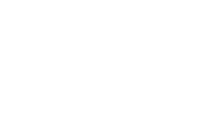
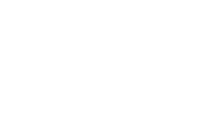
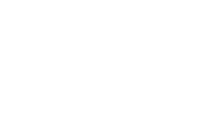

In [11]:
main().servable()